# 데이터 준비

In [1]:
!wget https://github.com/dhrim/deep_learning_data/raw/master/dogs_cats_yolo_labeled.zip

--2022-01-25 05:38:58--  https://github.com/dhrim/deep_learning_data/raw/master/dogs_cats_yolo_labeled.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/deep_learning_data/master/dogs_cats_yolo_labeled.zip [following]
--2022-01-25 05:39:05--  https://raw.githubusercontent.com/dhrim/deep_learning_data/master/dogs_cats_yolo_labeled.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5478153 (5.2M) [application/zip]
Saving to: ‘dogs_cats_yolo_labeled.zip’

dogs_cats_yolo_labe 100%[===================>]   5.22M  --.-KB/s    in 0.04s   

2022-01-25 05:39:05 (137 MB/s) - ‘dogs_cats_yolo_labele

In [2]:
!unzip dogs_cats_yolo_labeled.zip

Archive:  dogs_cats_yolo_labeled.zip
   creating: dogs_cats_yolo_labeled/
  inflating: dogs_cats_yolo_labeled/cat.99.jpg  
  inflating: dogs_cats_yolo_labeled/cat.99.xml  
  inflating: dogs_cats_yolo_labeled/cat.990.jpg  
  inflating: dogs_cats_yolo_labeled/cat.990.xml  
  inflating: dogs_cats_yolo_labeled/cat.9900.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9900.xml  
  inflating: dogs_cats_yolo_labeled/cat.9901.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9901.xml  
  inflating: dogs_cats_yolo_labeled/cat.9902.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9902.xml  
  inflating: dogs_cats_yolo_labeled/cat.9903.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9903.xml  
  inflating: dogs_cats_yolo_labeled/cat.9904.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9904.xml  
  inflating: dogs_cats_yolo_labeled/cat.9905.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9905.xml  
  inflating: dogs_cats_yolo_labeled/cat.9906.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9906.xml  
  inflating: d

# 이미지 파일 읽기

In [16]:
import glob

file_list = glob.glob("dogs_cats_yolo_labeled/*.jpg")
print(len(file_list))
print(file_list[:3])

222
['dogs_cats_yolo_labeled/dog.992.jpg', 'dogs_cats_yolo_labeled/dog.9938.jpg', 'dogs_cats_yolo_labeled/dog.9937.jpg']


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [18]:
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

In [19]:
dog_images = []
cat_images = []
for file_name in file_list:
    image = plt.imread(file_name)
    image = cv2.resize(image, (224,224))
    image = preprocessor(image)
    if "/dog" in file_name:
        dog_images.append(image)
    else:
        cat_images.append(image)

In [20]:
dog_images = np.array(dog_images)
cat_images = np.array(cat_images)
print(len(dog_images))
print(len(cat_images))

111
111


# Data Generator

In [21]:
BATCH_SIZE = 32

In [64]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence
from abc import *
import traceback

class DataGenerator(Sequence):

  def __init__(self, dog_images, cat_images, batch_size=BATCH_SIZE, shuffle=True):
    self.images = [ dog_images, cat_images ]
    self.batch_size = batch_size
    self.shuffle=shuffle
    self.on_epoch_end()

  def __len__(self):
    return math.ceil((len(self.images[0])+len(self.images[1]) )/ self.batch_size)

  def __getitem__(self, idx):
    batch_x0 = []
    batch_x1 = []
    batch_y = []
    for i in range(self.batch_size):
        c0, c1 = np.random.randint(2, size=2)
        batch_x0.append(self.images[c0][np.random.randint(len(self.images[c0]))])
        batch_x1.append(self.images[c1][np.random.randint(len(self.images[c1]))])
        batch_y.append(int(c0==c1))
    return (np.array(batch_x0), np.array(batch_x1)), np.array(batch_y)

  def on_epoch_end(self):
    pass


In [65]:
data_generator = DataGenerator(dog_images, cat_images)

(32, 224, 224, 3)


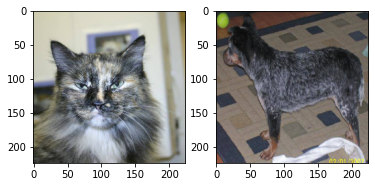

0


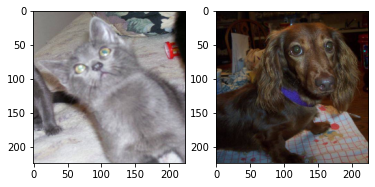

0


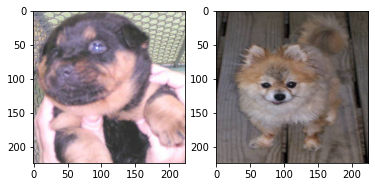

1


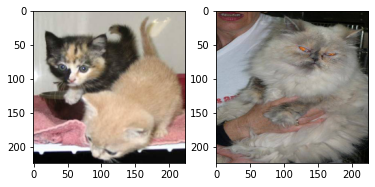

1


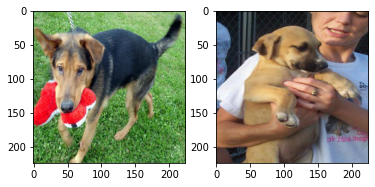

1


In [66]:
batch_x, batch_y = data_generator.__getitem__(0)
print(batch_x[0].shape)
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(batch_x[0][i])
    plt.subplot(1,2,2)
    plt.imshow(batch_x[1][i])
    plt.show()
    print(batch_y[i])


# 모델 정의와 학습

In [67]:
from tensorflow.python.keras.layers.merge import Concatenate
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Input, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

branch_input1 = Input((224,224,3))
x = conv_layers(branch_input1)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
branch_output1 = Dense(32, activation="relu", name="branch1_output")(x)

branch_input2 = Input((224,224,3))
x = conv_layers(branch_input2)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
branch_output2 = Dense(32, activation="relu", name="branch2_output")(x)


merged = Concatenate()([branch_output1, branch_output2])
x = Dense(10, activation="relu")(merged)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=(branch_input1, branch_input2), outputs=outputs)
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['acc'])
model.encoder = Model(inputs=[branch_input1], outputs=[branch_output1])

In [69]:
history = model.fit(data_generator, epochs=50)

Epoch 1/50
7/7 [==============================] - 1s 89ms/step - loss: 0.7045 - acc: 0.5312
Epoch 2/50
7/7 [==============================] - 1s 77ms/step - loss: 0.7098 - acc: 0.4777
Epoch 3/50
7/7 [==============================] - 1s 81ms/step - loss: 0.7005 - acc: 0.5357
Epoch 4/50
7/7 [==============================] - 1s 79ms/step - loss: 0.6630 - acc: 0.5759
Epoch 5/50
7/7 [==============================] - 1s 76ms/step - loss: 0.7280 - acc: 0.5089
Epoch 6/50
7/7 [==============================] - 1s 75ms/step - loss: 0.6612 - acc: 0.5045
Epoch 7/50
7/7 [==============================] - 1s 82ms/step - loss: 0.5993 - acc: 0.5893
Epoch 8/50
7/7 [==============================] - 1s 119ms/step - loss: 0.5217 - acc: 0.6786
Epoch 9/50
7/7 [==============================] - 0s 70ms/step - loss: 0.4015 - acc: 0.6652
Epoch 10/50
7/7 [==============================] - 1s 71ms/step - loss: 0.4974 - acc: 0.7188
Epoch 11/50
7/7 [==============================] - 0s 71ms/step - loss: 0.3112

# 영상 인코딩

In [83]:
images = np.vstack([dog_images, cat_images])
codes = model.encoder(images)

# 가까운 영상 찾기

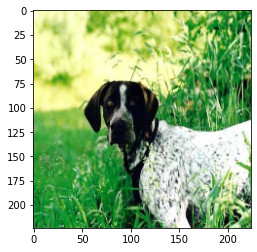

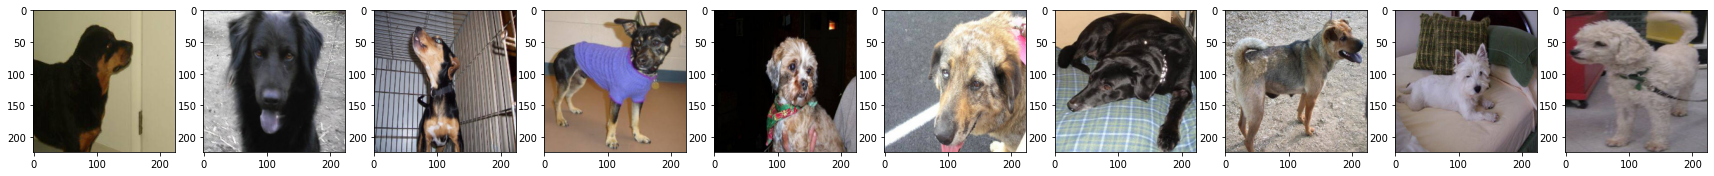

In [95]:
from scipy.spatial import distance

target_index = 5
target_image = images[target_index]
target_code = codes[target_index]

distances = [distance.euclidean(target_code, code) for code in codes]
similar_index = np.argsort(distances)

plt.imshow(target_image)
plt.show()
n = 10
plt.figure(figsize=(30,3))
for i in range(1,n+1):
    plt.subplot(1,n,i)
    plt.imshow(images[similar_index[i]])
plt.show()
